Connect google colab to my derive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Learning and controlling a room's temperature
### Farzad Vatandoust/email: vatandoustf@gamil.com

$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

## Section 1: Loading and analyzing the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:

# load dataset
dataset = pd.read_csv('/content/gdrive/My Drive/Temperature Control Project/data-B90102-30m.csv')
values = dataset.values
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                    time  room_temp  supply_temp  airflow_current
0  2021-04-26T09:37:00.0       72.3         59.3              416
1  2021-04-26T09:38:00.0       72.2         58.8              413
2  2021-04-26T09:39:00.0       72.2         58.5              419
3  2021-04-26T09:40:00.0       72.1         58.2              410
4  2021-04-26T09:41:00.0       71.9         58.1              404


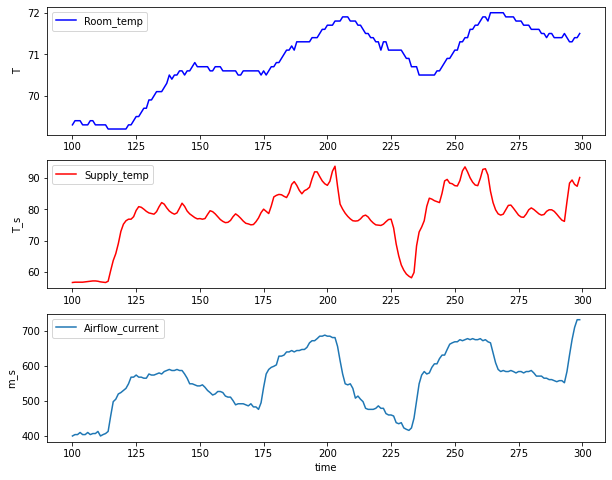

In [5]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

### Train/Test/Validation split (Global)
Useful link https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

In [6]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# Section 2: Learn a differential equation model

- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- scipy odeint : classical initial value problem solver
- solve_ivp + scipy: Did not performe well in optimization
- solve_ivp + casadi(IPOPT): Lets check it out later

Load required libraries

In [8]:
pip install casadi==3.5.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
import scipy
from casadi import *


Train/Test/Validation split

In [11]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
val_data= dataset[train_nu + test_nu: ]

## 2.1 solve_ivp + scipy

Solving the intial value problem 

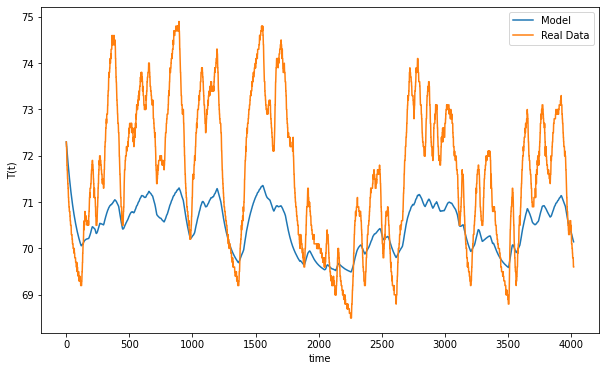

In [ ]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = np.array([50, 68.94, 0.005, 50, 4000.35])
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

Defining the objective function

In [ ]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    real = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    mse = sum((real-predicted)**2)/train_nu
    return mse

Testing the objective function

In [ ]:
p = np.array([10, 10, 10, 10, 1000])
objective_func(p)

172.24577883870975

Paramters estimation with optimization

In [ ]:
initial_condition = ([100, 70, 2, 10, 3000])
bnds = ((0, 300),
        (30, 100),
        (0.001, 10),
        (-100, 100),
        (1000, 10000))
Nfeval = 0
def mycallback(x):
  global Nfeval
  cost = objective_func(x)
  Nfeval += 1
  print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}  {6: 3.6f}'.format(Nfeval, x[0], x[1], x[2], x[3], x[4], cost))

print('{0:4s}        {1:9s}     {2:9s}   {3:9s}   {4:9s}     {5:9s}   {6:9s}'.format('Iter', 'K', 'Ta', 'ca', ' d', 'C', 'Cost')) 
res = scipy.optimize.minimize(objective_func, initial_condition, method='SLSQP', bounds=bnds, tol=1e-6, callback=mycallback)

Iter        K             Ta          ca           d            C           Cost     


/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


   1    100.233076    69.627567    0.001000    9.996264    3000.002312   5.587486
   2    100.240352    69.753255    1.926647    9.997517    3000.002386   138.068131
   3    100.245182    70.396566    0.032337    10.003936    3000.002489   0.539807
   4    100.255982    70.618545    0.021678    10.006152    3000.002654   0.355481
   5    100.254928    70.493179    0.024531    10.004901    3000.002692   0.336025
   6    100.253572    70.495182    0.024280    10.004921    3000.002751   0.335783
   7    100.251699    70.495336    0.024269    10.004922    3000.002813   0.335779
   8    100.235684    70.495882    0.024227    10.004926    3000.003340   0.335756
   9    100.180202    70.496795    0.024145    10.004930    3000.005167   0.335693
  10    100.043086    70.497816    0.024022    10.004931    3000.009680   0.335552
  11    99.639696    70.498953    0.023781    10.004918    3000.022955   0.335160
  12    98.590955    70.499077    0.023334    10.004862    3000.057466   0.334175
  13  

In [ ]:
# Julia results
p = np.array([44.79, 64.67, 0.011, 258.78, 2093.94])
a = objective_func(p)

p = np.array([62.62, 70.30, 0.017, 10.00, 3001.24])
b = objective_func(p)

print("Julia result :" + str(a))
print("Python result :" + str(b))

NameError: ignored

Display the optimized model

In [12]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = res.x
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

NameError: ignored

In [ ]:
p = [62.620063,    70.301263,    0.017046,    10.001907,    3001.241129]
z = solve_ivp(model, t_span=(0,1), y0=[70],
            args=(p, 90, 1000))

In [ ]:
z

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.35554182, 1.        ])
 t_events: None
        y: array([[70.        , 70.04360073, 70.12159045]])
 y_events: None

## 2.2 CasADi + ipopt

In [ ]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states,controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])



In [ ]:

# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": False, 'ipopt.max_iter':100}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Section 3: Learn  a Neural Network Model



## Section 3.1: LSTM via tensorflow

- Recurrent Neural Networks (RNN) by sentdex: https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7
- Multivariate Time Series Forecasting with LSTMs in Keras: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Load required libraries

In [7]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [8]:
# load dataset
dataset = read_csv('/content/gdrive/My Drive/Temperature Control Project/data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


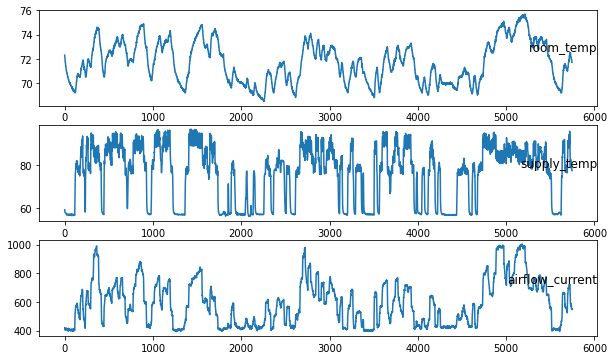

In [9]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure(figsize=(10, 6))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [20]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4022, 1, 3) (4022,) (862, 1, 3) (862,)


In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Save the Model
model.save('/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp')

In [ ]:
t = np.arange(0, len(inv_y))
pyplot.figure(figsize=(10, 6))
pyplot.plot(t, inv_y)
pyplot.plot(t, inv_yhat)
pyplot.legend(['real temp', 'predicted_temp'])
pyplot.show()

## Section 3.2: Pytorch

# Section 4: MPC

- Model Predictive Control by Steve Brunton : https://www.youtube.com/watch?v=YwodGM2eoy4

- John Hedengren site: https://apmonitor.com/do/index.php/Main/TCLabG
- https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8
- https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
- https://github.com/gasagna/mpc
- https://yalmip.github.io/example/standardmpc/
- https://www.itk.ntnu.no/fag/TTK4135/Pensum/MPCkompendium%20HOvd.pdf
- https://www.youtube.com/watch?v=DFqOf5wbQtc

Important paper: Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing https://www.mdpi.com/2227-7390/6/11/242/htm

- https://stackoverflow.com/questions/65720961/neural-network-mpc
- https://www.youtube.com/watch?v=uqivOJVbUNY
- https://www.youtube.com/watch?v=RrnkPrcpyEA

$Objective\:function = ||yt - y|| + c * \sum(a(T_s - 55) + b(\dot{m}_s-400) $

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000\:(Soft\:constraints)
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65\:(Hard\:constraints)$

Load required libraries

In [10]:
pip install casadi==3.5.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from casadi import *

## 4.1: Casadi + Equation 

In [ ]:
pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

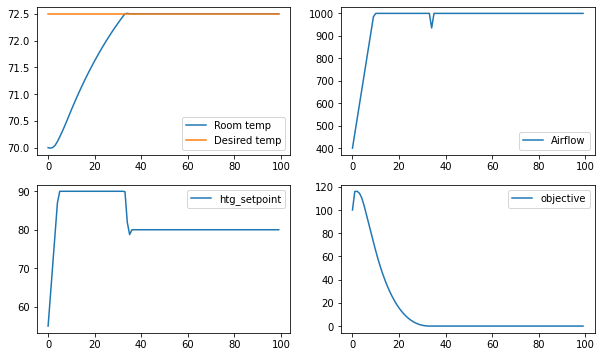

In [2]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

NP.random.seed(0)
N = 20 # Horizon length
dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states,controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])


# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": False, 'ipopt.max_iter':100}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Lets run our simulation 
x0 = 70.0
xs = 72.5

runtime = 100
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(100)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  # con_base = vertcat(min_Ts, min_Ms)
  st_next = phi(args['p'][0], sol['x'][0:2])

  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  xx.append(st_next)
  cost.append(sol['f'])
  TTs.append(sol['x'][0])
  MMs.append(sol['x'][1])

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()




## 4.2 CasADi + LSTM

In [13]:
import  keras
from os import stat_result
from casadi import *
import numpy as np
import tensorflow as tf
from casadi import Sparsity

In [14]:
LSTM_model = keras.models.load_model("/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp")

In [ ]:
import casadi
import tensorflow as tf

class TensorFlowEvaluator(casadi.Callback):
  def __init__(self,t_in,t_out,session, opts={}):
    """
      t_in: list of inputs (tensorflow placeholders)
      t_out: list of outputs (tensors dependeant on those placeholders)
      session: a tensorflow session
    """
    casadi.Callback.__init__(self)
    assert isinstance(t_in,list)
    self.t_in = t_in
    assert isinstance(t_out,list)
    self.t_out = t_out
    self.construct("TensorFlowEvaluator", opts)
    self.session = session
    self.refs = []

  def get_n_in(self): return len(self.t_in)
  def get_n_out(self): return len(self.t_out)

  def get_sparsity_in(self,i):
      return casadi.Sparsity.dense(*self.t_in[i].get_shape().as_list())

  def get_sparsity_out(self,i):
      return casadi.Sparsity.dense(*self.t_out[i].get_shape().as_list())

  def eval(self,arg):
    # Associate each tensorflow input with the numerical argument passed by CasADi
    d = dict((v,arg[i].toarray()) for i,v in enumerate(self.t_in))
    # Evaluate the tensorflow expressions
    ret = self.session.run(self.t_out,feed_dict=d)
    return ret

  # Vanilla tensorflow offers just the reverse mode AD
  def has_reverse(self,nadj): return nadj==1
  def get_reverse(self,nadj,name,inames,onames,opts):
    # Construct tensorflow placeholders for the reverse seeds
    adj_seed = [tf.placeholder(shape=self.sparsity_out(i).shape,dtype=tf.float64) for i in range(self.n_out())]
    # Construct the reverse tensorflow graph through 'gradients'
    grad = tf.gradients(self.t_out, self.t_in,grad_ys=adj_seed)
    # Create another TensorFlowEvaluator object
    callback = TensorFlowEvaluator(self.t_in+adj_seed,grad,self.session)
    # Make sure you keep a reference to it
    self.refs.append(callback)

    # Package it in the nominal_in+nominal_out+adj_seed form that CasADi expects
    nominal_in = self.mx_in()
    nominal_out = self.mx_out()
    adj_seed = self.mx_out()
    return casadi.Function(name,nominal_in+nominal_out+adj_seed,callback.call(nominal_in+adj_seed),inames,onames)



In [ ]:
import tensorflow as tf
with tf.Session() as session:
  model.initialize()
  GPR = GPR(model, session)

  w = vertcat(*w)

  # Create an NLP solver
  prob = {'f': GPR(w[0::3]), 'x': w , 'g': vertcat(*g)}
  options = {"ipopt": {"hessian_approximation": "limited-memory"}}
  solver = nlpsol('solver', 'ipopt', prob,options);

  # Solve the NLP
  sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

In [15]:
def F_LSTM(T, Ts, Ms):
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)

    scaled = scaler.transform(input)
    scaled_reframed = scaled.reshape((scaled.shape[0], 1, scaled.shape[1]))
    output = LSTM_model(scaled_reframed)
    inv_output = concatenate((output, scaled[:, 1:]), axis=1)
    inv_output = scaler.inverse_transform(inv_output)
    inv_output = inv_output[:,0]
    T_new = inv_output
    
    return T_new

In [16]:
F_LSTM(70, 65, 410)

array([69.99986], dtype=float32)

In [17]:
# Callback function for evaluating LSTM

class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    T = arg[0]
    Ts = arg[1]
    Ms = arg[2]
    f = F_LSTM(np.array(T), np.array(Ts), np.array(Ms))
    return [f[0]]

In [20]:
lstm = MyCallback('lstm', {"enable_fd":True})
print(lstm(70, 65, 410))

x = MX.sym("x")
y = MX.sym("y")
z = MX.sym("z")
print(lstm(x, y, z))

initializing object
69.9999
lstm(x, y, z){0}


In [19]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

NP.random.seed(0)
N = 5 # Horizon length
dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Lets run our simulation 
x0 = 70.0
xs = 72.5

runtime = 5
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(100)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  # con_base = vertcat(min_Ts, min_Ms)
  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])

  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  xx.append(st_next)
  cost.append(sol['f'])
  TTs.append(sol['x'][0])
  MMs.append(sol['x'][1])

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()




RuntimeError: ignored